# EX6 나의 첫 번째 캐글 경진대회.

****************
- 집의 정보를 가지고 가격을 예측하는 회귀문제
- 참여자들의 점수를 어떤 기준으로 평가하는지 
[RMSE(Root Mean Squared Error)]
- 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근

*************
**mkdir -p ~/aiffel/kaggle_kakr_housing/data**

**ln -s ~/data/data/*.csv ~/aiffel/kaggle_kakr_housing/data**

**ls ~/aiffel/kaggle_kakr_housing/data**
***************

In [47]:
# 필요한 라이브러리 import
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [48]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


In [49]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv



- train.csv : 모델 학습용파일, test.csv : 테스트용 파일, sample_submission.csv : 제출용 파일

### 데이터 불러오기

In [50]:
# 데이터 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [51]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [52]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

data.head()

21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 결측치 확인

- 누락된 데이터 존재시 제대로 역할을 하지 못한다.(결측치에 대해 처리)

<AxesSubplot:>

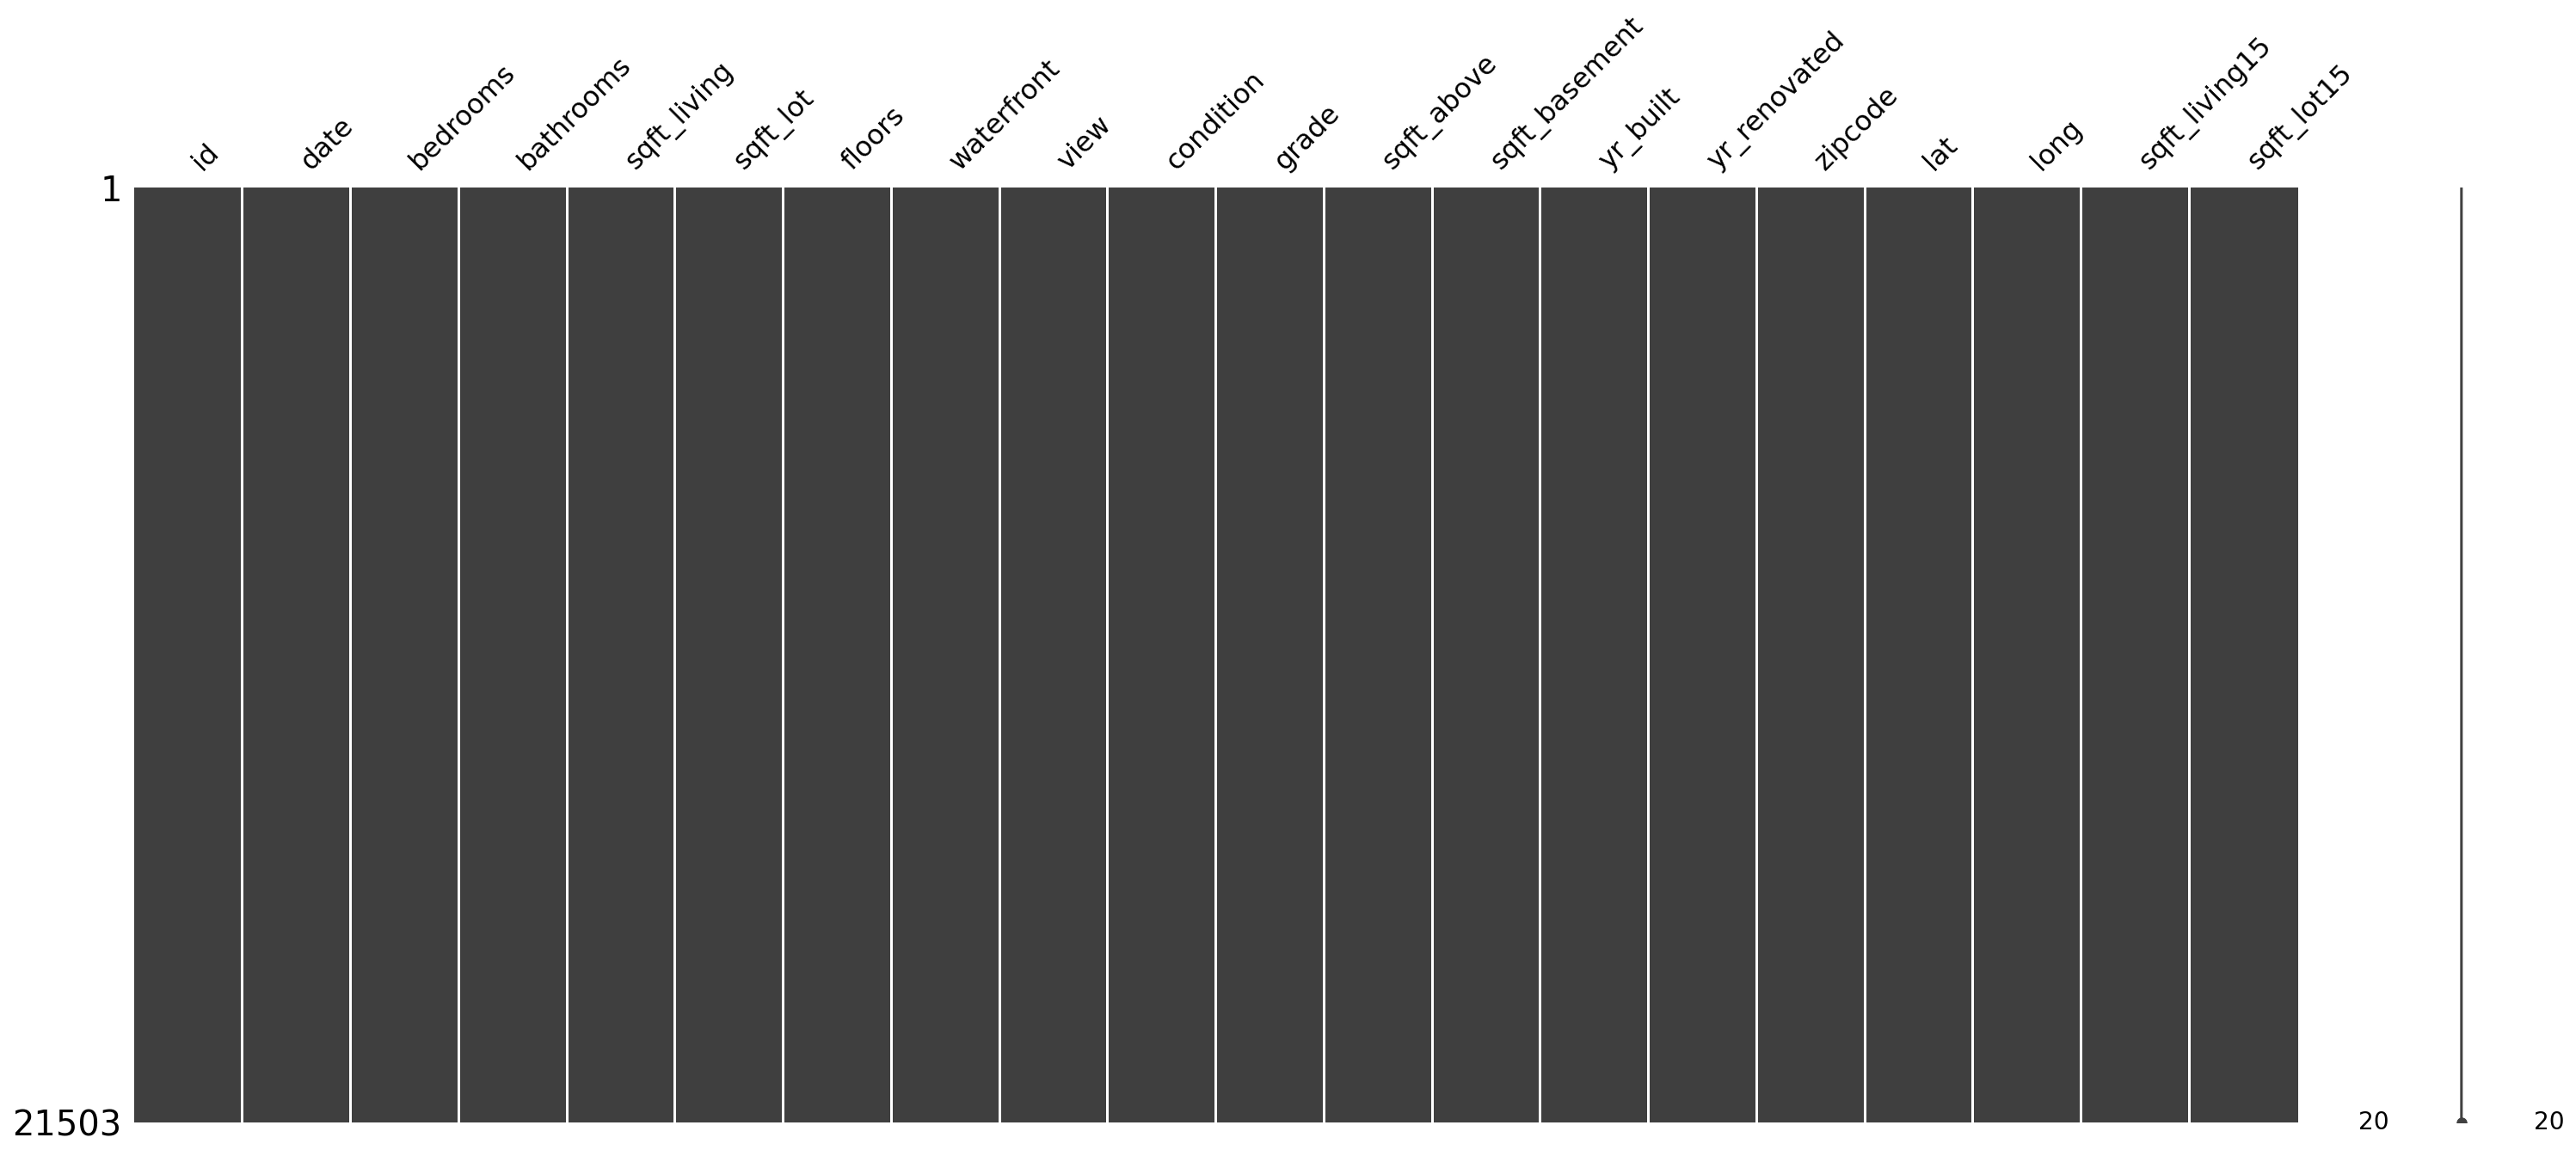

In [53]:
msno.matrix(data)
# 결측치가 존재할 때 검은 부분이 나오지 않음

In [54]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [55]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [56]:
# 3. 결측치인 데이터의 개수를 셉니다.
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [57]:
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


In [27]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [28]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [29]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


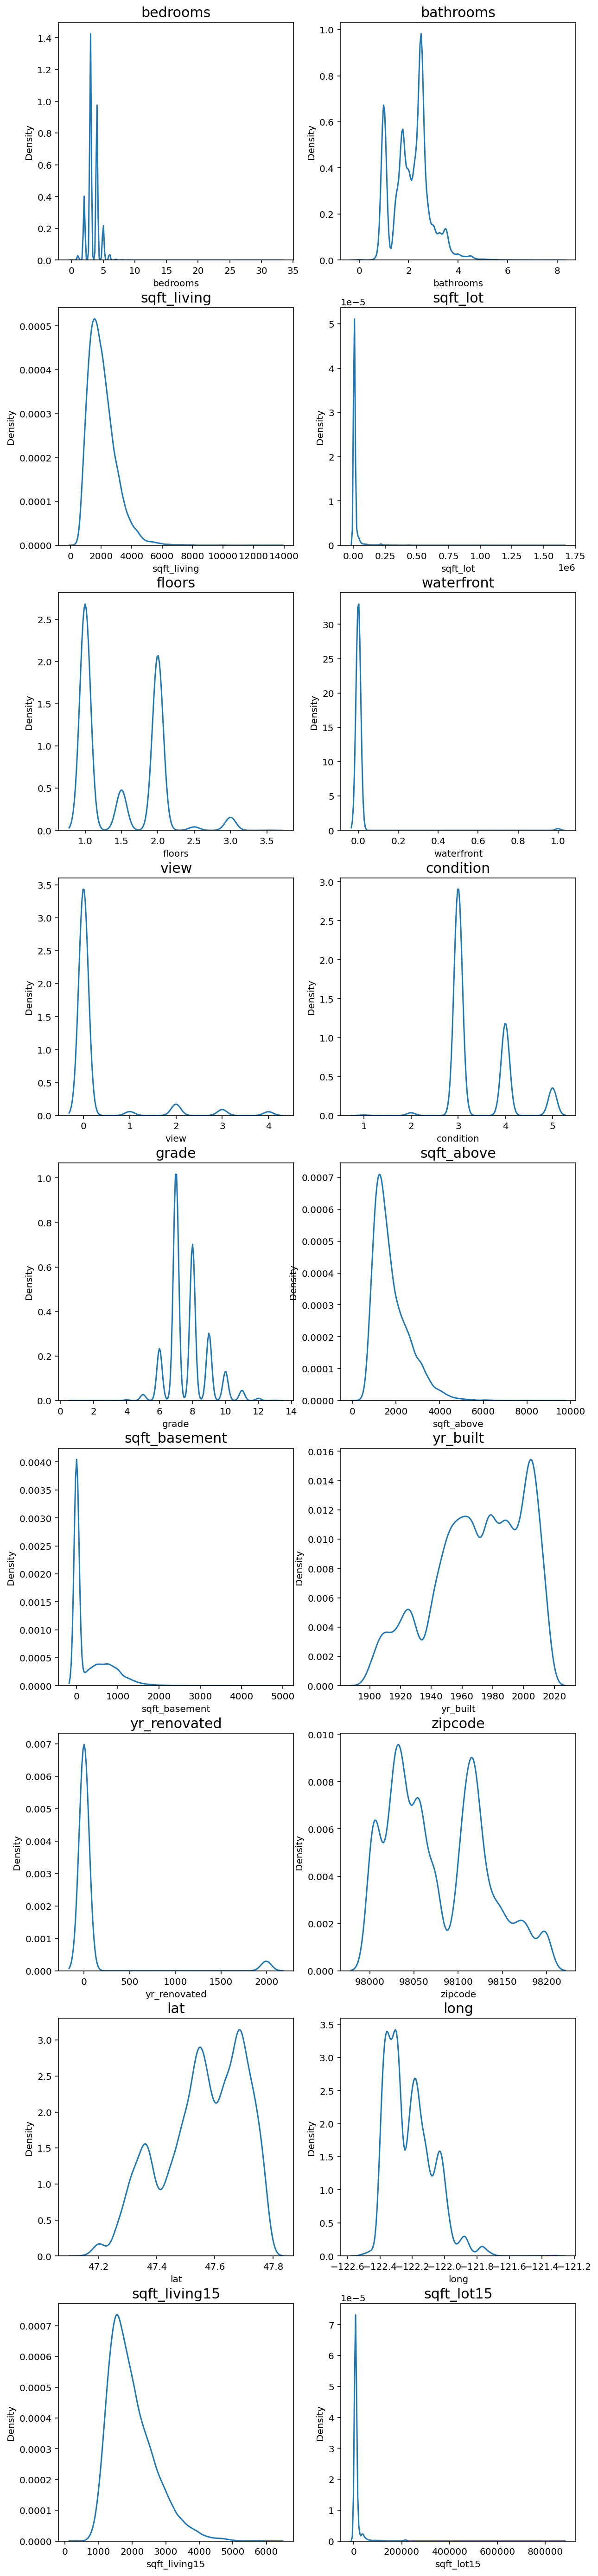

In [31]:
fig, ax = plt.subplots(9, 2, figsize=(10, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break
            
# 위 그래프 중에서는 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보이는군요. 

In [32]:
# 치우친 컬럼들을 skew_colums 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

얍💢


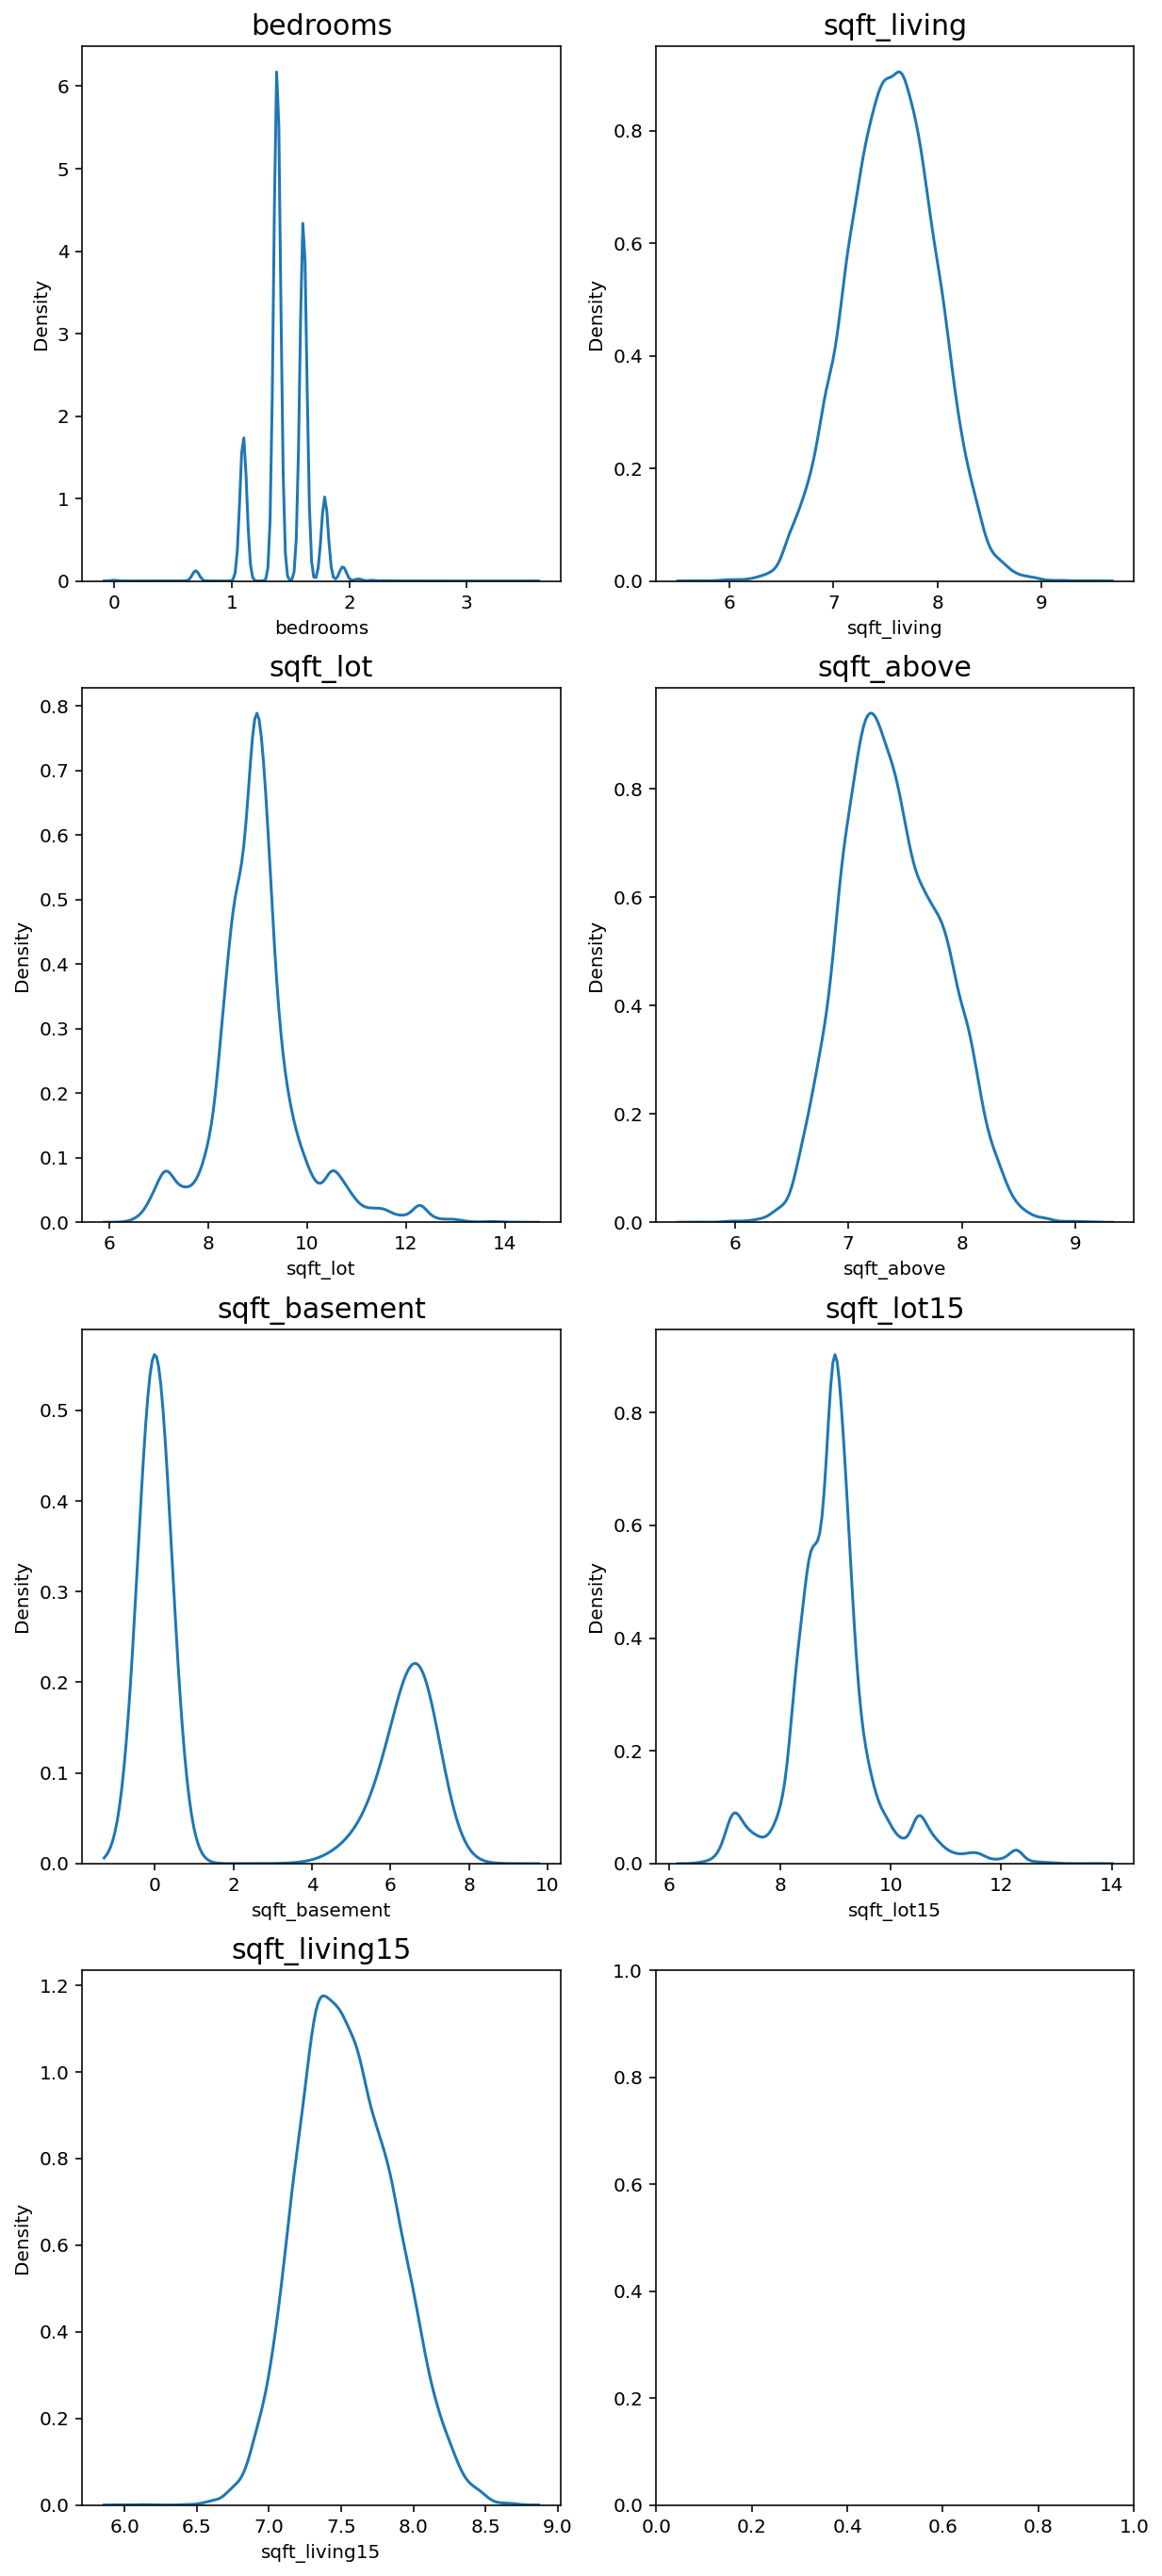

In [33]:
fig, ax = plt.subplots(4, 2, figsize=(10, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

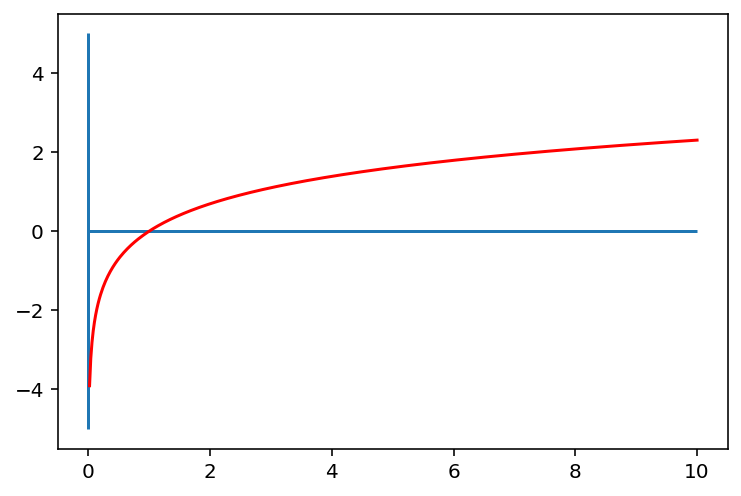

In [34]:
# 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있다.
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

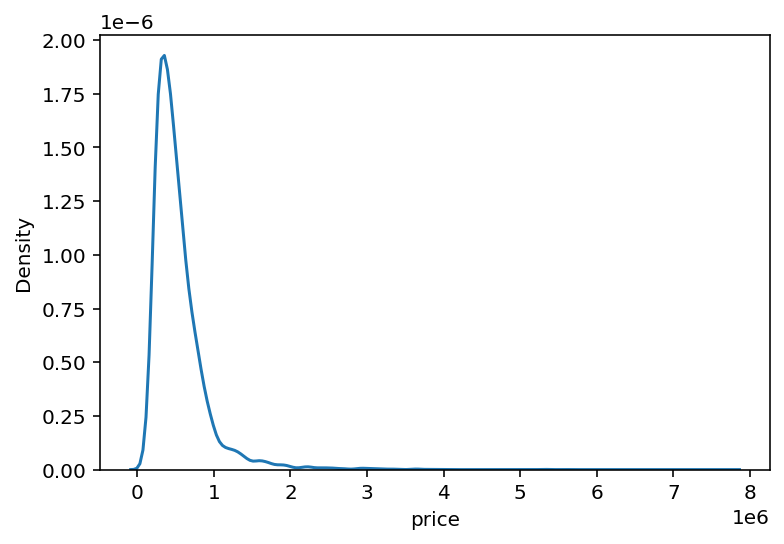

In [35]:
sns.kdeplot(y)
plt.show()

### log-scaling
- 로그 변환을 통해 데이터 분포를 정규분포에 가깝게 만든다.

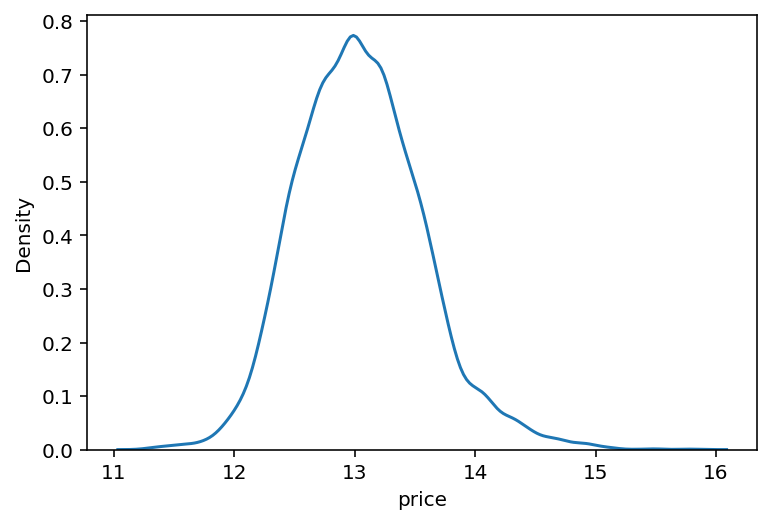

In [36]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [37]:
# : train_len 까지는 학습데이터, x에 저장
# train_len: 부터는 테스트데이터, sub 변수에 저장
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


- **블렌딩 : 다양한 여러 모델을 종합하여 결과를 얻는 기법**

***Voting : 여러 모델이 분류해 낸 결과들로부터 다수결 투표를 통해 최종 결과를 선택***

***Averaging : 각 모델이 계산한 실숫값들을 평균 혹은 가중평균하여 사용***

In [38]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [39]:
# Cross Validation : 교차검증을 통해 간단히 성능 평가
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

얍💢


In [40]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [41]:
# 결정계수 R squared
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [42]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [43]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [44]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [45]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


*****************
#### 여기까지 노드에서 진행한 방법으로 얻은 Private Score 값은 116130이다.

- 이제 하이퍼파라미터를 조정하여 다양하게 시도해보자.
*****************

## 목표 Private score 기준 110000 이하의 점수 얻기
**********************

### 튜닝해볼 수 있는 모델 클래스 인자

- max_depth : 의사 결정 나무의 깊이

- learning_rate : 한 스텝에 이동하는 양을 결정

- n_estimators : 사용하는 개별 모델의 개수

- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수

- boosting_type : 부스팅 방식

### 시도해볼 수 있는 방법

- 기존에 있는 데이터의 피처를 잘 표현할 수 있는 형태로 처리

- LGBMRegressor, XGBRegressor, RandomForestRegressor 등의 하이퍼 파라미터 튜닝하기

- 그리드 탐색을 시도해서 최적의 조합을 찾아보기

- 블렌딩 방법 활용하기(하나의 좋은 것보다, 다양한 것)

In [93]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [94]:
# 데이터 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [95]:
print("train : {}".format(train.shape))
print("test : {}".format(test.shape))

train : (15035, 21)
test : (6468, 20)


In [96]:
train.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,...,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,20140527T000000,468000.0,2,1.00,1160,6000,1.0,0,0,...,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,20140528T000000,310000.0,3,1.00,1430,19901,1.5,0,0,...,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,8,20141007T000000,400000.0,3,1.75,1370,9680,1.0,0,0,...,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,9,20150312T000000,530000.0,5,2.00,1810,4850,1.5,0,0,...,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


In [97]:
train['date'] = train['date'].apply(lambda i : i[:6]).astype(int)
train.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,201504,662500.0,3,2.50,3560,9796,1.0,0,0,...,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,201405,468000.0,2,1.00,1160,6000,1.0,0,0,...,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,201405,310000.0,3,1.00,1430,19901,1.5,0,0,...,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,8,201410,400000.0,3,1.75,1370,9680,1.0,0,0,...,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,9,201503,530000.0,5,2.00,1810,4850,1.5,0,0,...,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


In [98]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [99]:
# id column 삭제
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [100]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [101]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [108]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

### 데이터 전처리

In [109]:
train.isnull().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<AxesSubplot:>

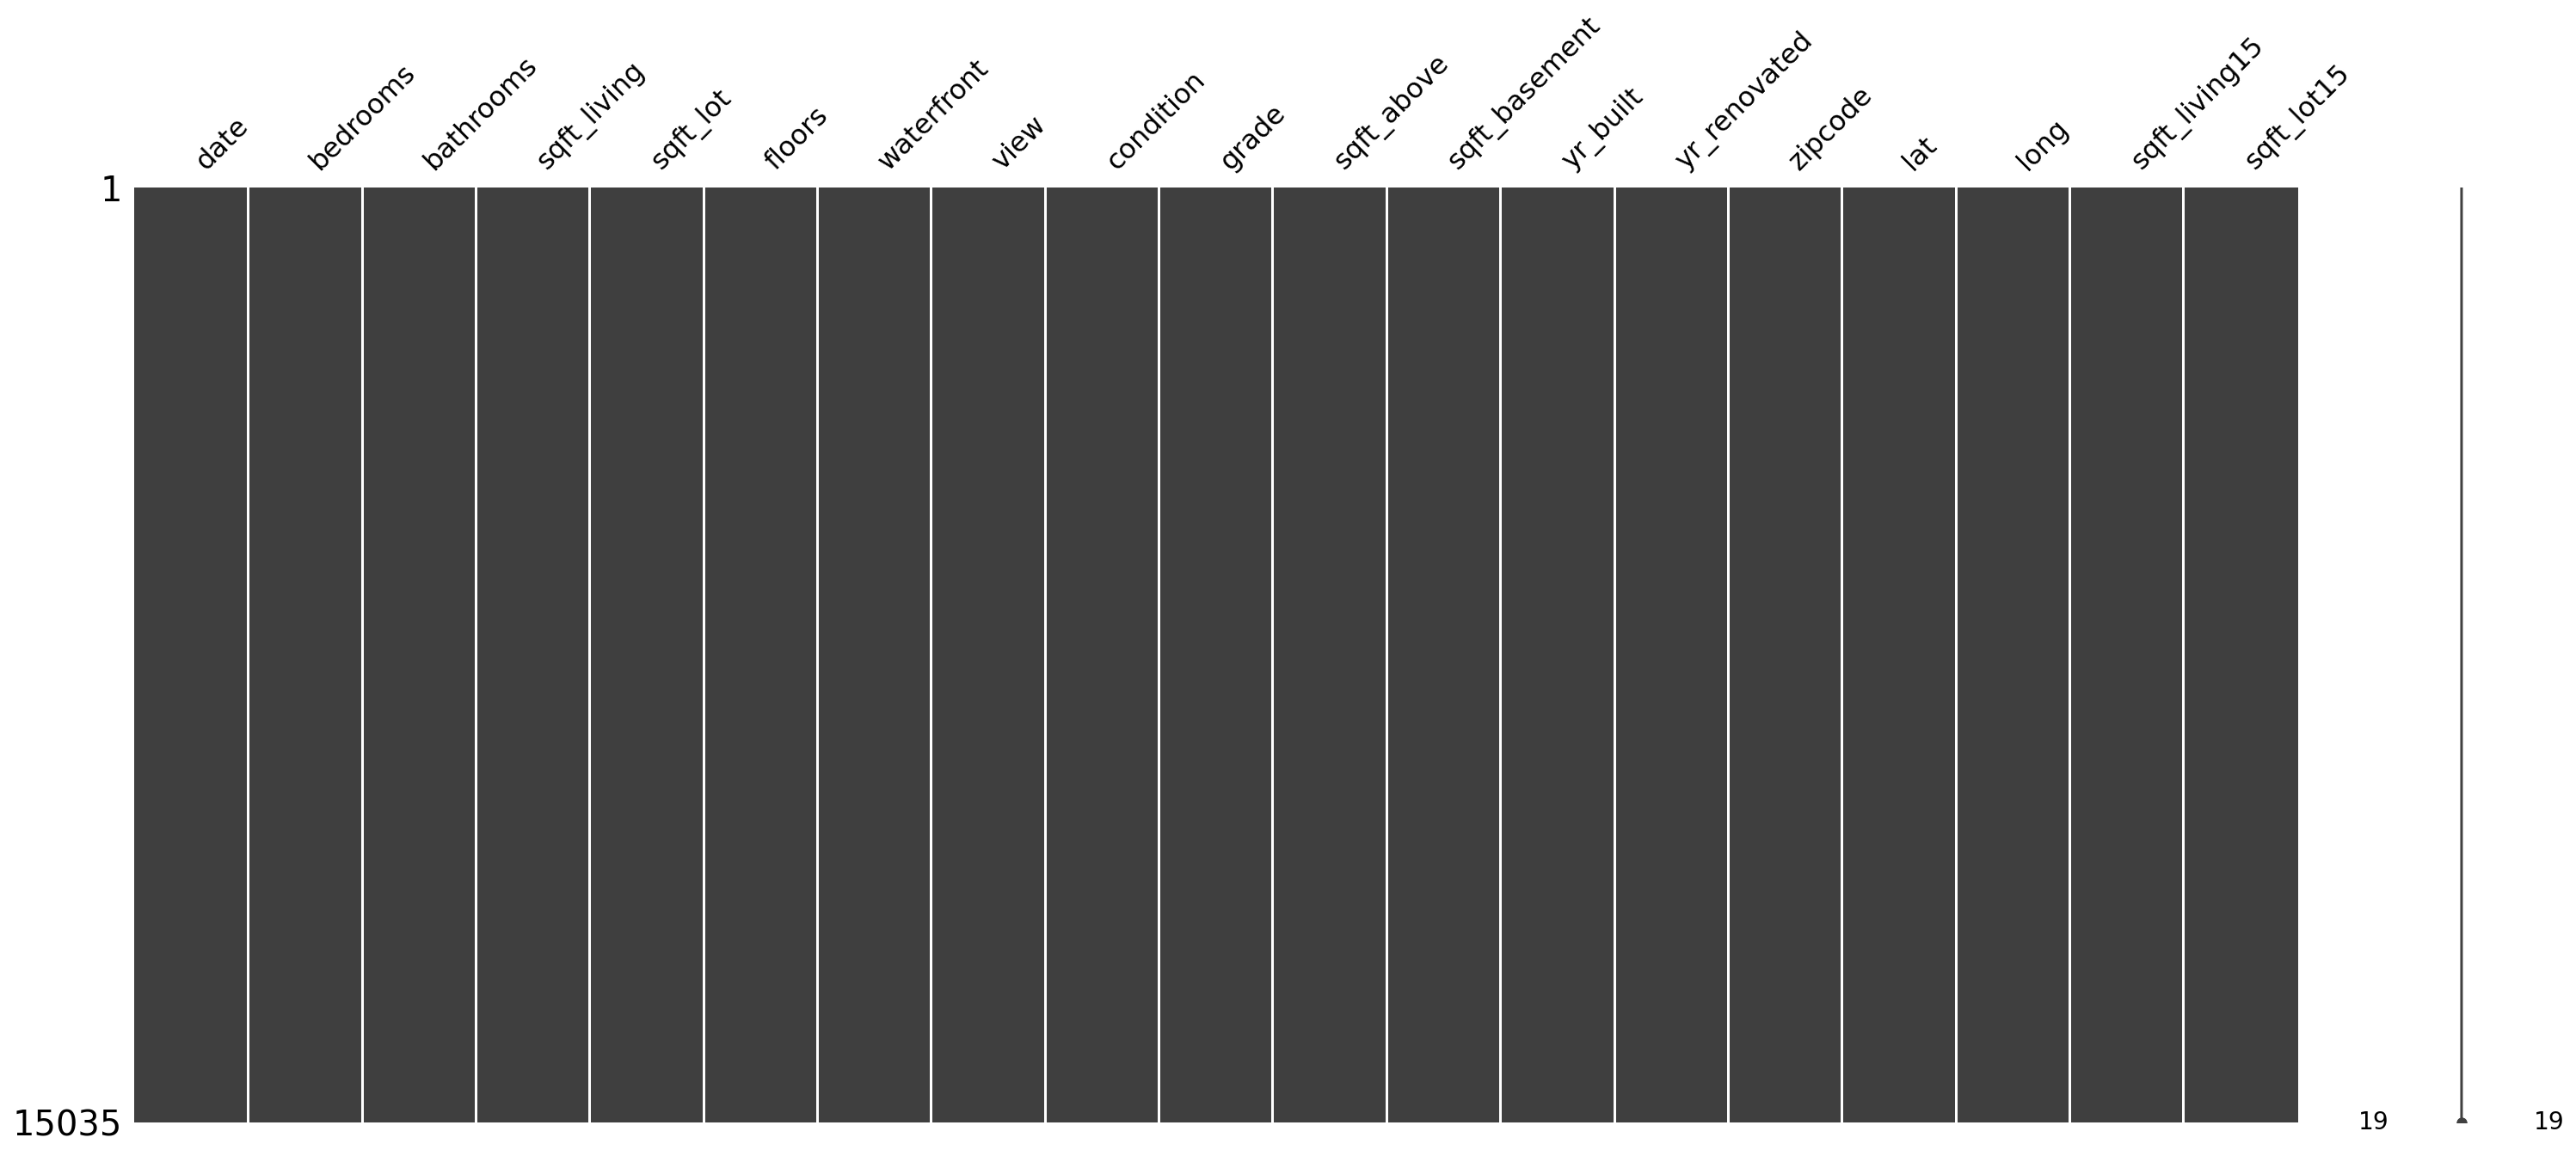

In [111]:
import missingno as msno
msno.matrix(train)

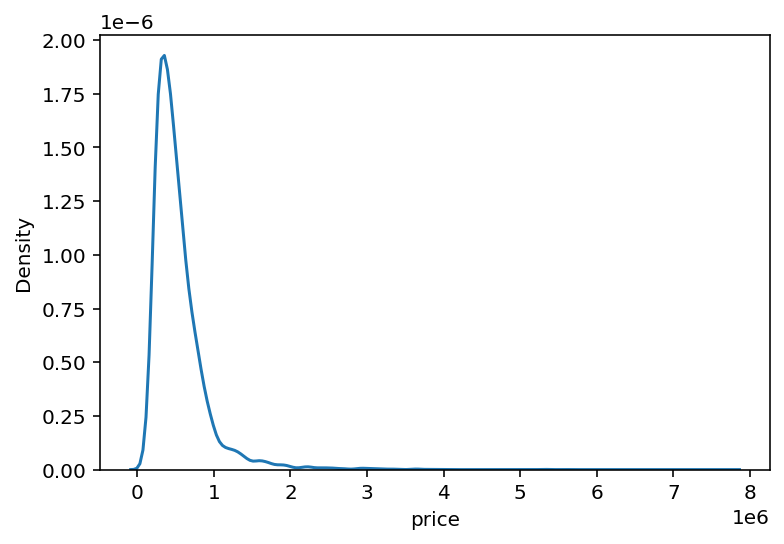

In [112]:
# seaborn의 kdeplot로 y 분포 확인
sns.kdeplot(y)
plt.show()

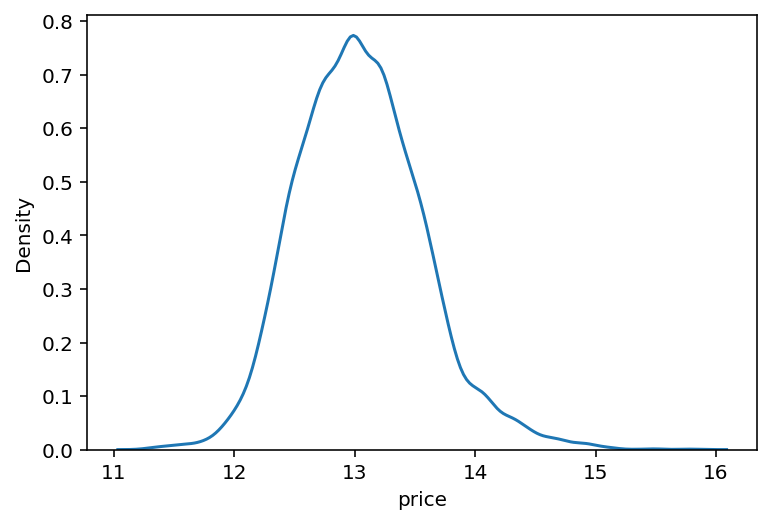

In [113]:
y = np.log1p(y)
y

sns.kdeplot(y)
plt.show()

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

- 전체 자료형 확인 : 모두 실수, 정수

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# RMSE 계산 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('RMSE 값 준비!')

RMSE 값 준비!


In [116]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [120]:
# random_state=2019의 값을 random_state=1000로 변경

random_state=1000

# 모델 인스턴스를 생성한 후 models라는 리스트에 넣어줍니다.
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [121]:
df = {}

for model in models:
    
    model_name = model.__class__.__name__

    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    df[model_name] = rmse(y_test, y_pred)
    
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 136006.12629797982,
 'XGBRegressor': 119718.06018913849,
 'LGBMRegressor': 124587.61719210431,
 'RandomForestRegressor': 135899.99104949637}

In [122]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

- Root Mean Square Error(RMSE) : 편차 제곱의 평균에 루트를 씌운 값.

In [123]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,136006.126298
RandomForestRegressor,135899.991049
LGBMRegressor,124587.617192
XGBRegressor,119718.060189


*************
### 그리드 탐색 Grid Search

- 하이퍼 파라미터에 넣을 수 있는 값들을 순차적으로 입력 후 가장 높은 성능을 보이 값을 찾는 방법

- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 갯수

- cv : train 데이터셋을 나누는 갯수

In [124]:
from sklearn.model_selection import GridSearchCV

In [159]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_depth': [1, 10, 20, 30],
}


In [160]:
# LightGBM를 사용
model = LGBMRegressor(random_state=random_state)

In [161]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   12.6s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=1000), n_jobs=5,
             param_grid={'max_depth': [1, 10, 20, 30],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=1)

In [162]:
grid_model.cv_results_

{'mean_fit_time': array([0.14617271, 0.18974628, 0.23383117, 0.35080523, 0.36424065,
        0.47359285, 0.93769064, 1.09680815, 0.30975881, 0.59011407,
        0.82853065, 1.24346948, 0.3193387 , 0.49832606, 0.88630233,
        0.95560155]),
 'std_fit_time': array([0.02851525, 0.06411149, 0.01836358, 0.09226153, 0.11153594,
        0.07448924, 0.33305365, 0.13075778, 0.07384569, 0.17271383,
        0.16198482, 0.28175099, 0.03462847, 0.15406902, 0.23429293,
        0.19793378]),
 'mean_score_time': array([0.00705624, 0.01384444, 0.01897407, 0.03250108, 0.01710896,
        0.02925396, 0.0683774 , 0.12096353, 0.01812325, 0.04084706,
        0.07417951, 0.10609293, 0.01494246, 0.03584213, 0.06478529,
        0.06718631]),
 'std_score_time': array([0.0002366 , 0.00611136, 0.0085229 , 0.01713774, 0.00613362,
        0.01104744, 0.01188928, 0.03363306, 0.00909293, 0.01733085,
        0.03065787, 0.0312894 , 0.00481537, 0.02352927, 0.0156658 ,
        0.01908533]),
 'param_max_depth': masked

In [163]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 25},
 {'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 1, 'n_estimators': 150},
 {'max_depth': 10, 'n_estimators': 25},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 150},
 {'max_depth': 20, 'n_estimators': 25},
 {'max_depth': 20, 'n_estimators': 50},
 {'max_depth': 20, 'n_estimators': 100},
 {'max_depth': 20, 'n_estimators': 150},
 {'max_depth': 30, 'n_estimators': 25},
 {'max_depth': 30, 'n_estimators': 50},
 {'max_depth': 30, 'n_estimators': 100},
 {'max_depth': 30, 'n_estimators': 150}]

In [164]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.10302959, -0.07339447, -0.05502043, -0.04842797, -0.03704046,
       -0.02917734, -0.02702714, -0.02645818, -0.03704359, -0.02919842,
       -0.02705114, -0.02646027, -0.03704359, -0.02919842, -0.02705114,
       -0.02646027])

In [165]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,25,-0.103030
1,1,50,-0.073394
2,1,100,-0.055020
3,1,150,-0.048428
4,10,25,-0.037040
5,10,50,-0.029177
6,10,100,-0.027027
7,10,150,-0.026458
8,20,25,-0.037044
9,20,50,-0.029198


In [166]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,25,-0.103030,0.320982
1,1,50,-0.073394,0.270914
2,1,100,-0.055020,0.234564
3,1,150,-0.048428,0.220064
4,10,25,-0.037040,0.192459
5,10,50,-0.029177,0.170814
6,10,100,-0.027027,0.164399
7,10,150,-0.026458,0.162660
8,20,25,-0.037044,0.192467
9,20,50,-0.029198,0.170875


- 음수가 나왔으니, -1을 곱해주고 np.sqrt로 루트 연산

In [167]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,25,-0.103030,0.320982
1,1,50,-0.073394,0.270914
2,1,100,-0.055020,0.234564
3,1,150,-0.048428,0.220064
4,10,25,-0.037040,0.192459
5,10,50,-0.029177,0.170814
6,10,100,-0.027027,0.164399
7,10,150,-0.026458,0.162660
8,20,25,-0.037044,0.192467
9,20,50,-0.029198,0.170875


In [168]:
# RMSLE가 낮은 순서대로 정렬해줍시다.
results.sort_values('RMSLE')

,max_depth,n_estimators,score,RMSLE
7,10,150,-0.026458,0.162660
11,20,150,-0.026460,0.162666
15,30,150,-0.026460,0.162666
6,10,100,-0.027027,0.164399
10,20,100,-0.027051,0.164472
14,30,100,-0.027051,0.164472
5,10,50,-0.029177,0.170814
9,20,50,-0.029198,0.170875
13,30,50,-0.029198,0.170875
4,10,25,-0.037040,0.192459


In [176]:
model = LGBMRegressor(max_depth=1, n_estimators=25, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.20492287, 12.8090154 , 13.63880016, ..., 13.06838536,
       12.95818035, 13.01487297])

In [177]:
prediction = np.expm1(prediction)
prediction

array([543030.64066313, 365496.74994134, 838021.4410929 , ...,
       473725.46860725, 424292.34813015, 449041.57053718])

In [178]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [179]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,543030.640663
1,15036,365496.749941
2,15037,838021.441093
3,15038,339357.470301
4,15039,330594.820502


In [181]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.320982')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.320982.csv


In [174]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [175]:
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [15, 20, 30], 
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:   16.0s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,score,RMSLE
2,20,300,-0.026091,0.161527
4,30,300,-0.026091,0.161527
3,20,400,-0.026206,0.161883
5,30,400,-0.026206,0.161883
0,15,300,-0.026269,0.162079
1,15,400,-0.026318,0.162228


In [143]:
model = LGBMRegressor(max_depth=20, n_estimators=300, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.12160458, 13.10226918, 14.15043868, ..., 13.05037436,
       12.67158278, 13.01735592])

In [144]:
prediction = np.expm1(prediction)
prediction

array([ 499619.74521686,  490052.17258291, 1397838.90879818, ...,
        465269.55869982,  318564.30877008,  450157.90324192])

In [146]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [147]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.996197e+05
1,15036,4.900522e+05
2,15037,1.397839e+06
3,15038,3.072446e+05
4,15039,3.279127e+05


In [156]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.161527')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161527.csv


In [157]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [158]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.161527')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161527.csv saved!


*****************
- 결과적으로 max_depth가 10, n_estimators가 100에서 최고의 Score가 나왔다. 	

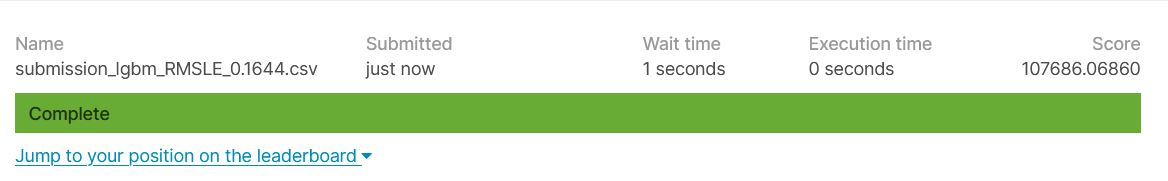

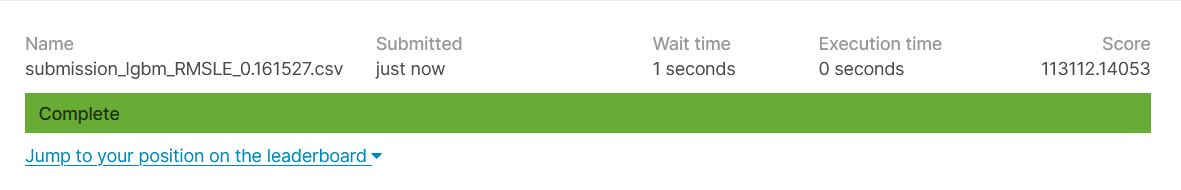

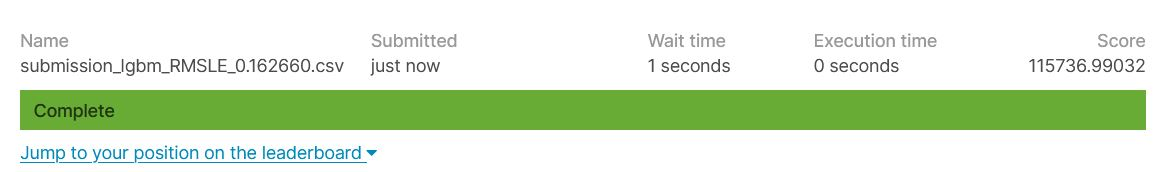

***********************
- max_depth가 1,n_estimators이 25인 최저의 score였던 .csv 파일을 넣었을때 점수가 궁금해서 넣었더니 2배 이상의 점수 차이가 났다.

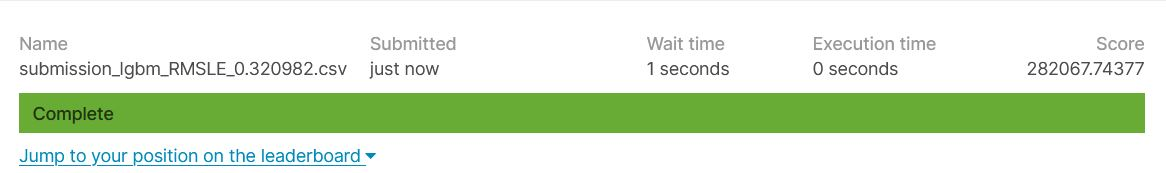

******************
## 회고

***LGBM과 XGB를 그리드 탐색해서 진행했다. (LGBM을 사용해서 목표치인 11만 이하를 찾아낼 수 있었다.)***

***해보면서 Random state도 조금의 영향이 있는것 같았다.(크지는 않지만 조금의 수치 변화가 있었다.)***

***지금의 현재 수준은 완벽한 이해를 통해 효율적으로 하이퍼 파라미터를 튜닝했다기 보다, depth와 estimators를 조금씩 바꾸면서 점수를 확인하는 방법을 사용했다. (사실상 노드만큼 완벽한 코드를 구현하는것이 아직까지는 힘들고, 검색과 물어봄으로써 배우고 있다.)***

***노드가 끝난후 두번째 시도에서 log scaling을 안했던것이 오류가 나서 머신러닝에서는 결측치 처리가 굉장히 중요하다는 것을 느끼게 되었다.***
- 아직 정확히 Kaggle에대해 이해를 못했다. youtube와 구글링을 통해서 너무 많은 모델 분석 기능이 있고, 분석과 데이터 전처리를 어떻게 하느냐에 따라 달라지는 것이 너무 많기에... 많은 공부가 필요하다.